In [ ]:

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'
import torch

# 确保PyTorch能够检测到GPU

In [2]:

import json
import time
import re
import itertools
import numpy as np
import pandas as pd
import datetime as DT
from tqdm import tqdm
from datetime import datetime
from scipy.optimize import curve_fit
from transformers import AutoModelForCausalLM, AutoTokenizer
from sentence_transformers import SentenceTransformer

/data/liangyunfei/miniconda3/envs/qwen/lib/python3.10/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/data/liangyunfei/miniconda3/envs/qwen/lib/python3.10/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


In [3]:

# Load pretrained LLM
QWEN2d5_7B_INST = "/data/liangyunfei/Qwen2.5-7B-Instruct"
QWEN2d5_32B_INST_AWQ = "/home/peizhengqi/Qwen/Qwen2.5-32B-Instruct-AWQ"
QWEN2d5_72B_INST_AWQ = "/data/liangyunfei/Qwen2.5-72B-Instruct-AWQ"

#model_7Bn = AutoModelForCausalLM.from_pretrained(QWEN2d5_7B_INST, device_map="auto")
#tokenizer_7Bn = AutoTokenizer.from_pretrained(QWEN2d5_7B_INST, device_map="auto")

model_32Bn = AutoModelForCausalLM.from_pretrained(QWEN2d5_72B_INST_AWQ, device_map="auto")
tokenizer_32Bn = AutoTokenizer.from_pretrained(QWEN2d5_72B_INST_AWQ, device_map="auto")



Loading checkpoint shards:   0%|          | 0/11 [00:00<?, ?it/s]

In [4]:
model = AutoModelForCausalLM.from_pretrained(QWEN2d5_7B_INST, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(QWEN2d5_7B_INST, device_map="auto")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:

from transformers import TextStreamer

streamer = TextStreamer(tokenizer_32Bn, skip_prompt=True, skip_special_tokens=True)

In [6]:
import json
with open('../饮食与营养管理.json', 'r') as file:
    rule_list = json.load(file)

In [7]:
rule_list[10]['messages'][1][24:]

'医生: 请问下午加餐了吗？'

In [8]:
len('2023-02-02 20:08:12.341 ')

24

In [11]:

sys_prompt1 = """
    You are a helpful, respectful and honest assistant. 
    Always answer as helpfully as possible, while being safe. 
    Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. 
    Please ensure that your responses are socially unbiased and positive in nature.
    If you don't know the answer to a question, please don't share false information.
"""
sys_prompt1 = '你是一个非常专业的糖尿病患者照护师,判断对方的意图，如果是低血糖和高血糖如何处理的问题，你需要知道对方的血糖值和所处的时间点（早餐前、早餐后、午餐前、午餐后、晚餐前、晚餐后、餐间时刻），否则正常进行对话'

def message_to_response_via_LLM(model, tokenizer, messages, max_new_tokens=256):

    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    generated_ids = model.generate(model_inputs.input_ids, max_new_tokens=max_new_tokens, do_sample=True, temperature=0.01, streamer=streamer)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)]
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return response
def message_to_response_no_stream(model, tokenizer, messages, max_new_tokens=256):

    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    generated_ids = model.generate(model_inputs.input_ids, max_new_tokens=max_new_tokens, do_sample=True, temperature=0.01)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)]
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return response

In [10]:
format_prompt = ""
res_messages = [
        
        {"role": "system", "content": sys_prompt1},
        {"role": "user", "content": query_prompt}
    ]
answer = ''
while True:
    
    query_prompt = input()#input()#"我吃的是咖喱饭"
    print(query_prompt)
    res_messages.append({"role": "system", "content": answer})
    res_messages.append({"role": "system", "content": query_prompt})
    answer = message_to_response_via_LLM(model_32Bn, tokenizer_32Bn, res_messages, max_new_tokens=1000)

NameError: name 'query_prompt' is not defined

In [ ]:
len(set(rule_list))

In [ ]:
filter_list = list(set(filter_list))

In [ ]:
filter_list

In [ ]:
len(filter_list)

In [ ]:
get_KB_list(output_food.split('，'))

In [ ]:
print('患者：')
query_prompt = '血糖低了怎么办'
print(query_prompt, '\n')
print('医生：')
format_prompt = f"从给定list中输出相关的部分，并换行分开,不要输出重复的东西"
filter_list = []
for  i in range(0, len(rule_list), 500):
    print(i)
    res_messages = [
        {"role": "system", "content": sys_prompt1},
        {"role": "user", "content": "给定一个饮食list：" + '\n'.join(rule_list[i:i+500])}, #+'\n'.join(get_KB_list(output_food.split('，')))
        {"role": "user", "content": query_prompt + format_prompt}
    ]
    llm_response = message_to_response_via_LLM(model_32Bn, tokenizer_32Bn, res_messages, max_new_tokens=1000)
    filter_list += llm_response.split('\n')
filter_list = list(set(filter_list))

In [ ]:
llm_response

In [ ]:

query_prompt = '对于糖尿病患者，鸡蛋一天应该吃几个，简短的告诉我'#input()#"我吃的是咖喱饭"
print('患者：')
print(query_prompt)
print('医生：')

bg_prompt = "已知今天的日期是：{}，北京时间。".format(time.asctime(time.localtime()))
format_prompt = " "


res_messages = [
    {"role": "system", "content": sys_prompt1},
    #{"role": "user", "content": "给定一个每种食物的组成成分和做法list："}, #+str(context_list)  +'\n'.join(caipu_list[:10])
    {"role": "user", "content": query_prompt}
]
llm_response = message_to_response_via_LLM(model_32Bn, tokenizer_32Bn, res_messages, max_new_tokens=1000)

In [ ]:
query_prompt = '请问一斤菠菜和一斤菠萝分别含有多少能量、蛋白质、糖类、脂肪'#input()#"我吃的是咖喱饭"
print('患者：')
print(query_prompt)
print('医生：')

bg_prompt = "已知今天的日期是：{}，北京时间。".format(time.asctime(time.localtime()))
format_prompt = "请严格按照食物组成成分和做法list，简短的回答我，脂肪和蛋白质不要算错了"


res_messages = [
    {"role": "system", "content": sys_prompt1},
    {"role": "user", "content": "给定一个每种食物的组成成分和做法list：" +'\n'.join(cost_list[:100])}, #+str(context_list)
    {"role": "user", "content": query_prompt+format_prompt}
]
llm_response = message_to_response_via_LLM(model_32Bn, tokenizer_32Bn, res_messages, max_new_tokens=1000)

In [ ]:
import json
postdata = json.dumps([{"userid":"123"}, {"userid":"124"}, {"userid":"789"}])


'[{"userid": "123"}, {"userid": "124"}, {"userid": "789"}]'

In [4]:
json.loads(postdata)

[{'userid': '123'}, {'userid': '124'}, {'userid': '789'}]

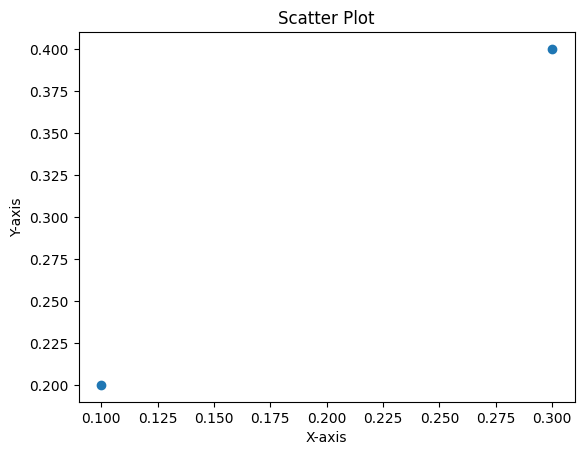

In [ ]:
import matplotlib.pyplot as plt

# 定义点的坐标
x = [1, 0.3]
y = [2, 0.4]

# 创建散点图
plt.scatter(x, y)

# 添加标题和标签
plt.title('Scatter Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# 显示图形
plt.show()


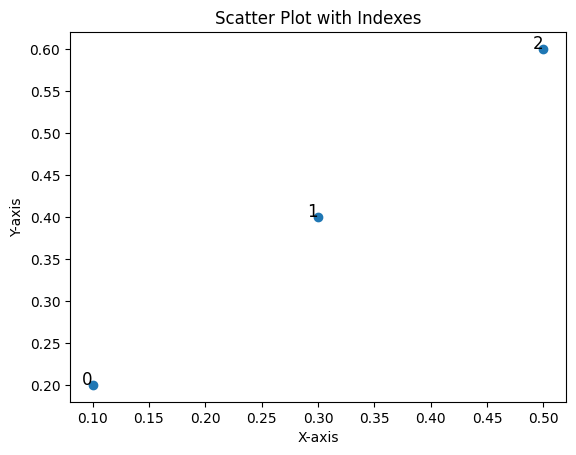

In [5]:
import matplotlib.pyplot as plt

# 定义点的坐标
points = [(0.1, 0.2), (0.3, 0.4), (0.5, 0.6)]

# 创建散点图
x, y = zip(*points)  # 解压列表中的元组
plt.scatter(x, y)

# 添加标题和标签
plt.title('Scatter Plot with Indexes')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# 为每个点添加索引标注
for i, (xi, yi) in enumerate(points):
    plt.text(xi, yi, str(i), fontsize=12, ha='right')

# 显示图形
plt.show()


In [3]:
x, y

((0.1, 0.3, 0.5), (0.2, 0.4, 0.6))

In [ ]:
similarity.cpu().numpy()